# Here is my implementation of multiple Linear Regression.

In [0]:
import numpy as np
import pandas as pd
import math
import itertools as it
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
from datetime import datetime

In [0]:
class OrdinaryLeastSquares(object):

  def __init__(self, X, y):
    self.model_type = 'OLS'
    self.predictors = X
    self.response = y
    self.response_pred = []
    self.coefficients = []
    self.residuals = []
    self.num_features = X.shape[1]
    self.num_obs = X.shape[0]

  
  def fit(self):
    # fit function calculates the coefficients
    X = self.predictors
    y = self.response

    if len(X.shape) == 1: X = self._reshape_x(X)

    X = self.__add_constant(X)
    self.coefficients = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

    self.__set_predicted()
      
  def predict(self, entry):
    # predict uses the coefficients to produce a prediction
    b0 = self.coefficients[0]
    betas = self.coefficients[1:]
    prediction = b0

    for xi, bi in zip(entry, betas): prediction += (bi * xi)
  
    return prediction
  
  def r_squared(self, actual = None, pred = None):
    if actual is None:
      actual = self.response
    if pred is None:
      pred = self.response_pred

    sst = 0
    ssr = 0
    act_mean = np.mean(actual)

    for i in range(self.num_obs):
      sst += (actual[i] - act_mean) ** 2
      ssr += (actual[i] - pred[i]) ** 2

    return 1 - (ssr / sst)
  
  def adj_r_squared(self, actual = None, pred = None):
    if actual is None:
      actual = self.response
    if pred is None:
      pred = self.response_pred

    n = self.num_obs
    p = self.num_features
    num = 1 - (1 - self.r_squared(actual, pred))
    den = (n - 1) / (n - p - 1)

    return num / den

  def LogLikelihood(self):
    n = self.num_obs
    k = self.num_features
    residuals = self.residuals

    ll = -(n * 1/2) * (1 + np.log(2 * np.pi)) - (n / 2) * np.log(residuals.dot(residuals) / n)

    return ll

  def AIC_BIC(self):
    ll = self.LogLikelihood()
    n = self.num_obs
    k = self.num_features + 1

    AIC = (-2 * ll) + (2 * k)
    BIC = (-2 * ll) + (k * np.log(n))
    
    return AIC, BIC

  def SE(self):
    X = self.predictors
    y = self.response
    pred = self.response_pred

    features = self.__add_constant(X)

    n = self.num_obs
    k = self.num_features

    MSE = (sum((y - pred) ** 2)) / (n - k)

    var_vals = MSE * (np.linalg.inv(features.T.dot(features)).diagonal())
    SE_vals = np.sqrt(var_vals)

    return SE_vals

  def p_values(self):
    params = self.coefficients
    SE_vals = self.SE()
    n = self.num_obs

    t_vals = params/ SE_vals
    p_vals = [2 * (1 - stats.t.cdf(np.abs(i), (n - 1))) for i in t_vals]
    
    return t_vals, p_vals

  def F_stat(self):
    df_e = self.num_obs - self.num_features - 1                       # degrees of freedom, error 
    df_r = self.num_features                                          # degrees of freedom, regression
    
    F = (self.r_squared() / df_r) / ((1 - self.r_squared()) / df_e)   # model F-statistic
    F_p = 1 - stats.f.cdf(F, df_r, df_e)                              # F-statistic p-value
    
    return F, F_p

  def dw(self):
    # Calculates the Durbin-Waston statistic
    de = np.diff(self.residuals, 1)
    dw = de.dot(de) / self.residuals.dot(self.residuals)

    return dw

  def omni(self):
    # Omnibus test for normality
    omni = stats.normaltest(self.residuals)[0]
    omni_p = stats.normaltest(self.residuals)[1]

    return omni, omni_p

  def skew_kurtosis(self):
    # Calculate residual skewness and kurtosis
    skew = stats.skew(self.residuals) 
    kurtosis = 3 + stats.kurtosis(self.residuals)

    return skew, kurtosis

  def JB(self):
    skew = self.skew_kurtosis()[0]
    kurtosis = self.skew_kurtosis()[1]

    # Calculate the Jarque-Bera test for normality
    JB = (self.num_obs / 6) * (np.square(skew) + (1 / 4) * np.square(kurtosis - 3))
    JB_p = 1 - stats.chi2.cdf(JB, self.num_features)

    return JB, JB_p

  def cond_num(self):
    return np.linalg.cond(self.__add_constant(self.predictors))

  def summary(self):
    full_report = self.__report()
    top_col1 = [i + ': ' + str(full_report['top_col1'][i]).rjust(30 - len(i)) for i in full_report['top_col1']]
    top_col2 = [i + ': ' + str(full_report['top_col2'][i]).rjust(30 - len(i)) for i in full_report['top_col2']]
    bottom_col1 = [i + ': ' + str(full_report['bottom_col1'][i]).rjust(30 - len(i)) for i in full_report['bottom_col1']]
    bottom_col2 = [i + ': ' + str(full_report['bottom_col2'][i]).rjust(30 - len(i)) for i in full_report['bottom_col2']]

    print(full_report['Title'].center(75))
    print('\n' + '===========================================================================' + '\n')

    for col1, col2 in it.zip_longest(top_col1, top_col2, fillvalue=''):
        print('{0:33}\t{1}'.format(col1, col2))

    print('\n' + '===========================================================================')

    print(full_report['var_report'])
    
    print('\n' + '===========================================================================')

    for col1, col2 in it.zip_longest(bottom_col1, bottom_col2, fillvalue=''):
        print('{0:33}\t{1}'.format(col1, col2))

    print('\n' + '===========================================================================')


  def __report(self):
    n = self.num_obs
    k = self.num_features
    r2 = np.round(self.r_squared(), 3)
    r2_adj = np.round(self.adj_r_squared(), 3)
    ll = np.round(self.LogLikelihood(), 2)
    AIC = np.round(self.AIC_BIC()[0])
    BIC = np.round(self.AIC_BIC()[1])
    SE_vals = np.round(self.SE(), 3)
    t_vals = np.round(self.p_values()[0], 3)
    p_vals = np.round(self.p_values()[1], 3)
    F_stat = np.round(self.F_stat()[0], 2)
    F_p = np.round(self.F_stat()[1], 2)
    # F_p = np.format_float_scientific(self.F_stat()[1], 2)
    omni = np.round(self.omni()[0], 3)
    omni_p = np.round(ols.omni()[1], 3)
    skew = np.round(self.skew_kurtosis()[0], 3)
    kurtosis = np.round(self.skew_kurtosis()[1], 3)
    dw = np.round(self.dw(), 3)
    JB = np.round(self.JB()[0], 3)
    JB_p = np.round(self.JB()[1], 3)
    cond_num = np.round(self.cond_num(), 3)
    params = np.round(self.coefficients, 4)
    

    current_date_time = datetime.now()
    date = current_date_time.strftime("%d/%m/%Y")
    time = current_date_time.strftime("%H:%M:%S")

    index_names = ['const' if i == 0 else 'x' + str(i) for i in range(0, k + 1)]
    report_df = pd.DataFrame(index = index_names)
    report_df["Coefficients"], report_df["Standard Errors"], report_df["t values"], report_df["P>|t|"] = [params, SE_vals, t_vals, p_vals]

    full_report = {
      'Title': 'Regression Results',
      'top_col1': {
        'Model': self.model_type,
        'No. Observations': n,
        'No. Features': k,
        'Date': date,
        'Time': time
      },
      'top_col2': {
        'R-squared': r2,
        'Adj. R-squared': r2_adj,
        'F-statistic': F_stat,
        'Prob (F-Statistic)': F_p,
        'Log-Likelihood': ll,
        'AIC': AIC,
        'BIC': BIC,
      },
      'bottom_col1': {
        'Omnibus': omni,
        'Prob (Omnibus)': omni_p,
        'Skew': skew,
        'Kurtosis': kurtosis,
      },
      'bottom_col2': {
        'Durbin-Watson': dw,
        'Jarque-Bera (JB)': JB,
        'Prob (JB)': JB_p,
        'Condition Number': cond_num
      },
      'var_report': report_df
    }

    return full_report

  def __reshape_x(self, X):
    return X.reshape(-1, 1)
  
  def __add_constant(self, X):
    ones = np.ones(shape=X.shape[0]).reshape(-1, 1)
    return np.concatenate((ones, X), 1)

  def __set_predicted(self):
    # save the predicted values for further analysis
    for row in self.predictors: self.response_pred.append(self.predict(row))
    self.residuals = np.subtract(self.response_pred, self.response)

# Testing the implementation on a dataset.

In [0]:
boston = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [0]:
X = boston.drop('medv', axis=1).values
y = boston['medv'].values

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [0]:
ols = OrdinaryLeastSquares(X_train, y_train)
ols.fit()

In [0]:
ols.predict(X_test)

array([   28.18412317,   120.54922314,  -261.94622337,    36.84845858,
          23.90018511,   -33.21578617, -1482.76011392,    30.13750699,
          20.09585837, -4804.82273186,  -155.52613387, -5481.98495672,
        -158.37180694])

In [0]:
y_pred = []
for row in X_test: y_pred.append(ols.predict(row))

In [0]:
pd.DataFrame({
    'Actual': y_test,
    'Predicted': np.ravel(y_pred)
})

,Actual,Predicted
0,28.4,31.078964
1,31.1,31.721694
2,23.5,30.873149
3,26.6,22.282350
4,19.6,18.856061
...,...,...
97,24.4,22.417851
98,22.6,26.727575
99,19.8,23.201172
100,22.2,23.918538


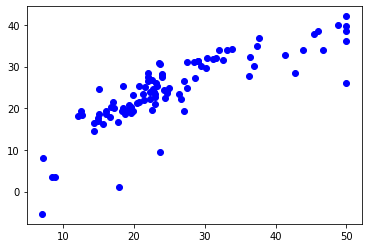

In [0]:
#plt.scatter(X, y)
#plt.plot(y)
plt.plot(y_test, y_pred, 'bo')
plt.show()

In [0]:
r2 = ols.r_squared()
r2 # r-squared is calculated for the train set by default

0.7501215345306078

In [0]:
r2_adj = ols.adj_r_squared()
r2_adj # adjusted r-squared is calculated for the train set by default

0.7259240656747817

In [0]:
ols.summary() # summary function that prints a table of metrics

                             Regression Results                            


Model:                       OLS 	R-squared:                  0.75
No. Observations:            404 	Adj. R-squared:            0.726
No. Features:                 13 	F-statistic:               90.06
Date:                 22/11/2019 	Prob (F-Statistic):          0.0
Time:                   01:30:46 	Log-Likelihood:         -1170.47
                                 	AIC:                      2369.0
                                 	BIC:                      2425.0

       Coefficients  Standard Errors  t values  P>|t|
const       36.5331            5.421     6.739  0.000
x1          -0.1282            0.032    -4.010  0.000
x2           0.0632            0.014     4.426  0.000
x3          -0.0076            0.063    -0.120  0.905
x4           1.9745            0.922     2.141  0.033
x5         -16.2720            3.960    -4.110  0.000
x6           3.1085            0.448     6.935  0.000
x7           0.0163 